# 章節 9：二維空間

## 9.6 條件分佈（Conditional Distributions）

邊際分佈包含獨立的變數資訊，但沒有呈現變數之間的相依關係（如果有關係的話）。

其中一個視覺化的方法是計算條件分佈。thinkbayes.Joint 類別提供一個方法計算條件分佈：

<pre>
# 回傳的結果表示第 i 個變數在第 j 個變數下條件數值為 val 的分佈

def Conditional(self, i, j, val):
    pmf = Pmf()
    for vs, prob in self.Items():
        # 判斷的條件
        if vs[j] != val: continue
        
        # 通過條件變放入機率分佈中
        pmf.Incr(vs[i], prob)
        
    pmf.Normalize()
    return pmf
</pre>

- i 是我們想知道變數的索引值
- j 是條件變數的索引值
- val 是條件的數值

下方的程式碼計算 alpha 在不同 beta 值下的條件分佈（將9.5小節的程式碼放到下方）：

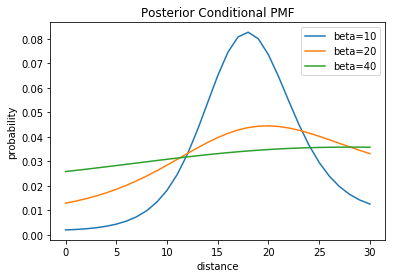

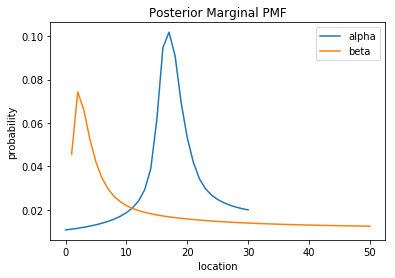

In [11]:
import thinkbayes as tb
import math
import matplotlib.pyplot as plt
import numpy as np


def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

    
# Paintball 繼承自 Suite 以及 Joint
class Paintball(tb.Suite, tb.Joint):
    
    def __init__(self, alphas, betas, locations):
        # alphas：一序列的 alpha 值
        # betas：一序列的 beta 值
        
        # 所有可能漆彈的位置；為了之後 Likelihood 方法使用
        self.locations = locations
        
        # pairs：所有 alpha, beta 的配對
        pairs = [(alpha, beta)
            for alpha in alphas
            for beta in betas
        ]
        
        tb.Suite.__init__(self, pairs)
    
    
    def Likelihood(self, data, hypo):
        # alpha, beta：假設敵人的位置
        alpha, beta = hypo

        # x：觀察到的牆面漆彈位置
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)

        # 從建立好的 pmf 得到漆彈位置的似然性
        like = pmf.Prob(x)
        return like
        

# 計算每個位置被漆彈打到的機率，跟掃射速度成反比
def MakeLocationPmf(alpha, beta, locations):
    # alpha, beta：敵人的座標
    # locations：一序列牆上漆彈的位置

    pmf = tb.Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
        
    pmf.Normalize()
    # 回傳漆彈位置與其對應的機率
    return pmf       


def StrafingSpeed(alpha, beta, x):
    # alpha, beta：敵人的座標
    # x：牆上漆彈的位置
    
    
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    
    # 回傳 x 對 theta 的微分
    return speed

alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)
suite = Paintball(alphas, betas, locations)

# 根據牆上漆彈位置更新先驗分佈
suite.UpdateSet([15, 16, 18, 21])

# 計算後驗的邊際分佈
marginal_alpha = suite.Marginal(0)
marginal_beta = suite.Marginal(1)


# 計算 alpha 在不同 beta 值下的條件分佈
betas = [10, 20, 40]
legends = []
plt.title("Posterior Conditional PMF")
plt.xlabel("distance")
plt.ylabel("probability")
for beta in betas:
    cond = suite.Conditional(0, 1, beta)
    plot_dist(cond)
    legends.append("beta=%d" % beta)
    
plt.legend(legends)
plt.show()

plt.title("Posterior Marginal PMF")
plt.xlabel("location")
plt.ylabel("probability")
plot_dist(marginal_alpha)
plot_dist(marginal_beta)
plt.legend(["alpha", "beta"])
plt.show()

上圖的結果為「後驗條件分佈」。如果變數間是獨立的，那條件分佈與邊際分佈會一致。因為都不一樣，所以我們說 alpha 與 beta 是有相關的。例如若我們知道 beta = 10，則 alpha 的後驗條件分佈會比較窄。對數值較大的 beta ， alpha 的後驗條件分佈會比較寬。